In [1]:
import torch, sys, os
print(sys.prefix)

/home/labsisfo/miniconda3/envs/vio-cw


# 1. Project Setup

## 1.1. Package Import

In [2]:
import os, csv, json, random, shutil
from dataclasses import dataclass
from typing import Optional

import numpy as np
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms

import timm
from torchmetrics.classification import BinaryF1Score, BinaryAUROC
from sklearn.metrics import confusion_matrix

from torchvision import transforms
import random as pyrand

import io, random
import torchvision.transforms as T

import math, statistics
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

import glob

from sklearn.metrics import roc_curve, auc as sk_auc, precision_recall_curve, f1_score, confusion_matrix
import numpy as np

from collections import Counter

import uuid, socket, getpass, time, math
from datetime import datetime
from typing import Optional, Dict, Any, Tuple

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold

/home/labsisfo/miniconda3/envs/vio-cw/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
    torch.backends.cudnn.benchmark = True

Device: cuda
GPU: NVIDIA GeForce RTX 4060 Ti


In [4]:
try:
    from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
except Exception as e:
    raise RuntimeError("Install: pip install scikit-learn") from e

## 1.2. Configurations

In [5]:
@dataclass
class TrainConfig:
    train_csv: str = "data/splits/train.csv"
    val_csv:   str = "data/splits/val.csv"
    test_csv:  str = "data/splits/test.csv"
    img_size:  int = 320
    robust_aug: bool = True

    batch_size: int = 32
    num_workers: int = 4
    use_class_weight: bool = True
    use_weighted_sampler: bool = False

    epochs: int = 400
    lr: float = 3e-4
    weight_decay: float = 1e-4
    early_stop_patience: int = 15
    seed: int = 42
    amp: bool = True

    model_name: str = "efficientnetv2_l"
    num_classes: int = 2

    use_distill: bool = False
    teacher_ckpt: str = "models/server/best_server.pt"
    distill_alpha: float = 0.5
    distill_T: float = 6.0

    out_dir: str = "experiments/runs/student_cv_no_distill"
    save_best_name: str = "best_model.pt"

cfg = TrainConfig()

## 1.3. Reproducibility

In [6]:
def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(cfg.seed)

# 2. Dataset

## 2.1. Data Initialization

In [7]:
class CSVDataset(Dataset):
    def __init__(self, csv_path: str, transform=None):
        self.samples = []
        with open(csv_path, "r", newline="") as f:
            reader = csv.reader(f)
            header = next(reader)
            if header and header[0].lower() != "path":  # no header case
                f.seek(0); reader = csv.reader(f)
            for row in reader:
                if len(row) >= 2:
                    p, y = row[0], int(row[1])
                    self.samples.append((p, y))
        self.transform = transform

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        p, y = self.samples[idx]
        img = Image.open(p).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, torch.tensor(y, dtype=torch.long)

In [8]:
def load_csv(path: str):
    if not os.path.exists(path):
        raise FileNotFoundError(f"CSV tidak ditemukan: {path}")
    rows = []
    with open(path, "r", newline="") as f:
        rd = csv.reader(f)
        header = next(rd, None)
        # Jika kolom pertama bukan "path", berarti tidak ada header -> ulang dari awal
        if header and str(header[0]).lower() != "path":
            f.seek(0)
            rd = csv.reader(f)
        for r in rd:
            if not r: 
                continue
            p = r[0]
            y = int(r[1]) if len(r) > 1 and r[1] != "" else 0
            rows.append((p, y))
    return rows


In [9]:
train_csv = "data/splits/train.csv"
val_csv   = "data/splits/val.csv"
test_csv  = "data/splits/test.csv"

train = load_csv(train_csv)
val   = load_csv(val_csv)
test  = load_csv(test_csv)

splits = {"train": train, "val": val, "test": test}

## 2.3. Data Preprocessing

In [10]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

In [11]:
def safe_open_rgb(path):
    img = Image.open(path)
    if img.mode in ("RGBA", "LA", "P"):
        img = img.convert("RGBA")
        bg = Image.new("RGB", img.size, (0, 0, 0))
        bg.paste(img, mask=img.split()[-1])
        img = bg
    elif img.mode != "RGB":
        img = img.convert("RGB")
    return img

In [12]:
old_getitem = CSVDataset.__getitem__
def _patched_getitem(self, idx):
    p, y = self.samples[idx]
    try:
        img = safe_open_rgb(p)
    except Exception as e:
        from PIL import Image
        img = Image.new("RGB", (cfg.img_size, cfg.img_size), (0,0,0))
    if self.transform:
        img = self.transform(img)
    import torch
    return img, torch.tensor(y, dtype=torch.long)

CSVDataset.__getitem__ = _patched_getitem

In [13]:
class RandomJpegArtifacts(torch.nn.Module):
    """
    Simulate JPEG compression artifacts in-memory (no disk I/O).
    p: probability to apply
    q_range: (min_quality, max_quality)
    """
    def __init__(self, p=0.3, q_range=(40, 70)):
        super().__init__()
        self.p = p
        self.q_range = q_range

    def forward(self, img):
        if random.random() > self.p:
            return img
        buf = io.BytesIO()
        q = random.randint(*self.q_range)
        img.save(buf, format="JPEG", quality=q, optimize=False)  # artifacts
        buf.seek(0)
        comp = Image.open(buf)
        if comp.mode != "RGB":
            comp = comp.convert("RGB")
        return comp

In [14]:
class RandomLowLight(torch.nn.Module):
    """
    Random low-light via simple gamma-like reduction on value.
    """
    def __init__(self, p=0.3, scale_range=(0.6, 0.9)):
        super().__init__()
        self.p = p
        self.scale_range = scale_range

    def forward(self, img):
        if random.random() > self.p:
            return img
        s = random.uniform(*self.scale_range)
        return img.point(lambda v: int(v * s))

In [15]:
def build_transforms(img_size=320, robust_aug=True):
    train_list = [
        T.Resize((img_size, img_size)),
        T.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(),
        T.ColorJitter(brightness=0.2, contrast=0.2),
    ]
    if robust_aug:
        train_list += [
            RandomLowLight(p=0.3, scale_range=(0.6, 0.9)),
            RandomJpegArtifacts(p=0.3, q_range=(40, 70)),
        ]
    train_list += [T.ToTensor(), T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]

    val_tf = T.Compose([
        T.Resize((img_size, img_size)),
        T.ToTensor(),
        T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
    ])
    return T.Compose(train_list), val_tf

train_tf, val_tf = build_transforms(cfg.img_size, cfg.robust_aug)

In [16]:
cfg.num_workers = 2

In [17]:
train_ds = CSVDataset(cfg.train_csv, transform=train_tf)
val_ds   = CSVDataset(cfg.val_csv,   transform=val_tf)
test_ds  = CSVDataset(cfg.test_csv,  transform=val_tf)

In [18]:
train_sampler = None
if cfg.use_weighted_sampler:
    labels = [y for _, y in train_ds.samples]
    import numpy as np
    class_count = np.bincount(labels, minlength=2)
    class_weight = 1.0 / np.maximum(class_count, 1)
    sample_weight = [class_weight[y] for y in labels]
    train_sampler = WeightedRandomSampler(sample_weight, num_samples=len(sample_weight), replacement=True)

## 2.4. Data Loading

In [19]:
train_dl = DataLoader(train_ds, batch_size=cfg.batch_size,
                      shuffle=(train_sampler is None), sampler=train_sampler,
                      num_workers=cfg.num_workers, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False,
                      num_workers=cfg.num_workers, pin_memory=True)
test_dl  = DataLoader(test_ds, batch_size=cfg.batch_size, shuffle=False,
                      num_workers=cfg.num_workers, pin_memory=True)
print("Rebuilt loaders with num_workers =", cfg.num_workers)

Rebuilt loaders with num_workers = 2


In [20]:
def channel_stats_after_transform(rows, transform, k=256):
    import numpy as np
    ps = [p for p,_ in rows]
    sample = ps if len(ps)<=k else np.random.choice(ps, k, replace=False)
    xs=[]
    for p in sample:
        with Image.open(p) as im:
            im = im.convert("RGB")
            xs.append(transform(im))
    X = torch.stack(xs)  # [N,3,H,W]
    mean = X.mean(dim=(0,2,3)).cpu().numpy()
    std  = X.std(dim=(0,2,3)).cpu().numpy()
    return mean, std

In [21]:
mean_tr, std_tr = channel_stats_after_transform(splits["train"], train_tf, k=256)
mean_va, std_va = channel_stats_after_transform(splits["val"],   val_tf,   k=256)
print("Train tensor mean/std:", mean_tr, std_tr)
print("Val   tensor mean/std:", mean_va, std_va)

/home/labsisfo/miniconda3/envs/vio-cw/lib/python3.10/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train tensor mean/std: [ 0.1465757  -0.04446741  0.0505291 ] [1.3325001 1.3861123 1.3848997]
Val   tensor mean/std: [0.47585347 0.236899   0.3582972 ] [1.4827062 1.562989  1.5922033]


In [22]:
class RowsDataset(Dataset):
    def __init__(self, rows, transform):
        self.rows = rows
        self.transform = transform
    def __len__(self):
        return len(self.rows)
    def __getitem__(self, i):
        p, y = self.rows[i]
        im = Image.open(p).convert("RGB")
        x = self.transform(im) if self.transform else im
        return x, torch.tensor(y, dtype=torch.long)


In [23]:
def compute_class_weight_from_rows(rows, num_classes=2, min_count_eps=1e-6):
    """
    rows: list of (path, label)
    return: torch.FloatTensor shape [num_classes]
    """
    counts = Counter([lbl for _, lbl in rows])
    # pastikan semua kelas ada
    weights = []
    total = sum(counts.values())
    for c in range(num_classes):
        cnt = counts.get(c, 0)
        # skema umum: weight_c = total / (num_classes * count_c)
        w = total / (max(cnt, min_count_eps) * num_classes)
        weights.append(w)
    w = torch.tensor(weights, dtype=torch.float32)
    return w

# 3. Model

## 3.1. Model Factory

In [24]:
def create_model(name: str, num_classes: int = 2, pretrained: bool = True):
    alias = {
        "efficientnetv2_l": "tf_efficientnetv2_l",
    }
    name = alias.get(name, name)
    return timm.create_model(name, pretrained=pretrained, num_classes=num_classes)

In [25]:
@torch.inference_mode()
def measure_latency_ms_per_image(model, img_size=224, device=None, batch_size=1,
                                 warmup=20, iters=100, amp=True):
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.eval().to(device)
    x = torch.randn(batch_size, 3, img_size, img_size, device=device)
    if device == "cuda":
        torch.cuda.synchronize()
    for _ in range(warmup):
        with torch.amp.autocast('cuda', enabled=(amp and device=="cuda")):
            _ = model(x)
    if device == "cuda":
        torch.cuda.synchronize()
    t0 = time.perf_counter()
    for _ in range(iters):
        with torch.amp.autocast('cuda', enabled=(amp and device=="cuda")):
            _ = model(x)
    if device == "cuda":
        torch.cuda.synchronize()
    t1 = time.perf_counter()
    total_ms = (t1 - t0) * 1000.0
    ms_per_batch = total_ms / iters
    ms_per_img   = ms_per_batch / batch_size
    ips          = 1000.0 / ms_per_img
    return ms_per_img, ips

## 3.2. Distillation

In [26]:
class DistillLoss(nn.Module):
    """
    total = alpha * CrossEntropy(student_logits, y_true)
          + (1-alpha) * KL(softmax(student/T) || softmax(teacher/T)) * T^2
    """
    def __init__(self, alpha=0.5, T=2.0, ce_weight=None):
        super().__init__()
        self.alpha = alpha
        self.T = T
        # <-- pakai class weight jika diberikan
        self.ce = nn.CrossEntropyLoss(weight=ce_weight)

    def forward(self, s_logits, y_true, t_logits=None):
        ce = self.ce(s_logits, y_true)
        if t_logits is None:
            return ce
        log_p_s = F.log_softmax(s_logits / self.T, dim=1)
        p_t     = F.softmax(t_logits / self.T, dim=1)
        kd = F.kl_div(log_p_s, p_t, reduction="batchmean") * (self.T**2)
        return self.alpha * ce + (1 - self.alpha) * kd


In [27]:
def run_one_epoch(model, dl, optimizer=None, scaler=None, criterion=None, teacher=None, kd: Optional[DistillLoss]=None):
    training = optimizer is not None
    model.train(training)

    loss_sum = 0.0
    f1 = BinaryF1Score().to(device)
    auc = BinaryAUROC().to(device)

    for x, y in dl:
        x = x.to(device, non_blocking=True); y = y.to(device, non_blocking=True)

        if training:
            optimizer.zero_grad(set_to_none=True)
            with torch.no_grad():
                t_logits = teacher(x) if (teacher is not None) else None
            with torch.amp.autocast('cuda', enabled=(scaler is not None)):
                s_logits = model(x)
                loss = (kd(s_logits, y, t_logits) if kd is not None else criterion(s_logits, y))
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad():
                s_logits = model(x)
                loss = (kd(s_logits, y, teacher(x)) if (kd and teacher) else criterion(s_logits, y))

        p = torch.softmax(s_logits, dim=1)[:,1]
        f1.update(p, y.bool()); auc.update(p, y.bool())
        loss_sum += loss.item() * x.size(0)

    n = len(dl.dataset)
    return loss_sum/n, f1.compute().item(), auc.compute().item()

## 3.3. Train Loop & Early Stopping

In [28]:
def compute_class_weight_from_ds(ds: CSVDataset):
    labels = [y for _, y in ds.samples]
    counts = np.bincount(labels, minlength=2)
    total  = counts.sum()
    weights = total / (2.0 * np.maximum(counts, 1))
    return torch.tensor(weights, dtype=torch.float32).to(device), counts

In [29]:
# def train_model_with_loaders(cfg: TrainConfig, train_dl_local, val_dl_local, verbose: int = 1, log_csv: bool = False):
#     os.makedirs(cfg.out_dir, exist_ok=True)
#     set_seed(cfg.seed)

#     model = create_model(cfg.model_name, cfg.num_classes).to(device)

#     try:
#         train_rows_src = getattr(train_dl_local.dataset, 'rows', None)
#     except Exception:
#         train_rows_src = None

#     cw = None
#     if train_rows_src is not None:
#         cw = compute_class_weight_from_rows(train_rows_src, num_classes=cfg.num_classes).to(device)
#         if verbose:
#             from collections import Counter
#             cnt = Counter([lbl for _, lbl in train_rows_src])
#             # print(f"class counts: {dict(cnt)} | class weights: {cw.tolist()}")

#     teacher = None
#     kd_loss = None
#     if cfg.use_distill:
#         assert os.path.exists(cfg.teacher_ckpt), f"Teacher ckpt not found: {cfg.teacher_ckpt}"
#         teacher = create_model("efficientnetv2_l", cfg.num_classes).to(device)
#         teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))
#         teacher.eval()
#         for p in teacher.parameters():
#             p.requires_grad = False
#         kd_loss = DistillLoss(alpha=cfg.distill_alpha, T=cfg.distill_T, ce_weight=cw)

#     criterion = nn.CrossEntropyLoss(weight=cw)

#     optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
#     scaler = torch.amp.GradScaler('cuda', enabled=cfg.amp)

#     best_auc, bad = -1.0, 0
#     best_path = os.path.join(cfg.out_dir, cfg.save_best_name)

#     if log_csv:
#         import csv
#         with open(os.path.join(cfg.out_dir, "train_log.csv"), "w", newline="") as f:
#             csv.writer(f).writerow(["epoch","tr_loss","tr_f1","tr_auc","va_loss","va_f1","va_auc"])

#     for epoch in range(1, cfg.epochs + 1):
#         tr_loss, tr_f1, tr_auc = run_one_epoch(
#             model, train_dl_local, optimizer, scaler, criterion, teacher, kd_loss
#         )
#         va_loss, va_f1, va_auc = run_one_epoch(
#             model, val_dl_local, None, None, criterion, teacher, kd_loss
#         )

#         # if verbose:
#         #     print(f"[{epoch:02d}/{cfg.epochs}] "
#         #           f"train: loss={tr_loss:.4f} f1={tr_f1:.3f} auc={tr_auc:.3f} | "
#         #           f"val: loss={va_loss:.4f} f1={va_f1:.3f} auc={va_auc:.3f}")

#         if log_csv:
#             with open(os.path.join(cfg.out_dir, "train_log.csv"), "a", newline="") as f:
#                 import csv
#                 csv.writer(f).writerow([epoch, tr_loss, tr_f1, tr_auc, va_loss, va_f1, va_auc])

#         # early stopping by val AUC
#         if va_auc > best_auc:
#             best_auc, bad = va_auc, 0
#             torch.save(model.state_dict(), best_path)
#         else:
#             bad += 1
#             if bad >= cfg.early_stop_patience:
#                 if verbose:
#                     print("Early stopping triggered.")
#                 break

#     if verbose:
#         print("Best val AUC:", round(best_auc, 4), "| saved:", best_path)
#     return best_path, best_auc


# EARLY STOP F1
def train_model_with_loaders(cfg: TrainConfig, train_dl_local, val_dl_local, verbose: int = 1, log_csv: bool = False):
    os.makedirs(cfg.out_dir, exist_ok=True)
    set_seed(cfg.seed)

    model = create_model(cfg.model_name, cfg.num_classes).to(device)

    try:
        train_rows_src = getattr(train_dl_local.dataset, 'rows', None)
    except Exception:
        train_rows_src = None

    cw = None
    if train_rows_src is not None:
        cw = compute_class_weight_from_rows(train_rows_src, num_classes=cfg.num_classes).to(device)
        if verbose:
            from collections import Counter
            cnt = Counter([lbl for _, lbl in train_rows_src])
            print(f"class counts: {dict(cnt)} | class weights: {cw.tolist()}")

    teacher = None
    kd_loss = None
    if cfg.use_distill:
        assert os.path.exists(cfg.teacher_ckpt), f"Teacher ckpt not found: {cfg.teacher_ckpt}"
        teacher = create_model("efficientnetv2_l", cfg.num_classes).to(device)
        teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))
        teacher.eval()
        for p in teacher.parameters():
            p.requires_grad = False
        kd_loss = DistillLoss(alpha=cfg.distill_alpha, T=cfg.distill_T, ce_weight=cw)

    criterion = nn.CrossEntropyLoss(weight=cw)

    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scaler = torch.amp.GradScaler('cuda', enabled=cfg.amp)

    # track best F1 instead of best AUC
    best_f1, bad = -1.0, 0
    best_path = os.path.join(cfg.out_dir, cfg.save_best_name)

    if log_csv:
        import csv
        with open(os.path.join(cfg.out_dir, "train_log.csv"), "w", newline="") as f:
            csv.writer(f).writerow(["epoch","tr_loss","tr_f1","tr_auc","va_loss","va_f1","va_auc"])

    for epoch in range(1, cfg.epochs + 1):
        tr_loss, tr_f1, tr_auc = run_one_epoch(
            model, train_dl_local, optimizer, scaler, criterion, teacher, kd_loss
        )
        va_loss, va_f1, va_auc = run_one_epoch(
            model, val_dl_local, None, None, criterion, teacher, kd_loss
        )

        if verbose:
            print(f"[{epoch:02d}/{cfg.epochs}] "
                  f"train: loss={tr_loss:.4f} f1={tr_f1:.3f} auc={tr_auc:.3f} | "
                  f"val: loss={va_loss:.4f} f1={va_f1:.3f} auc={va_auc:.3f}")

        if log_csv:
            with open(os.path.join(cfg.out_dir, "train_log.csv"), "a", newline="") as f:
                import csv
                csv.writer(f).writerow([epoch, tr_loss, tr_f1, tr_auc, va_loss, va_f1, va_auc])

        # early stopping by val F1 (bukan AUC lagi)
        if va_f1 > best_f1:
            best_f1, bad = va_f1, 0
            torch.save(model.state_dict(), best_path)
        else:
            bad += 1
            # if bad >= cfg.early_stop_patience:
            #     if verbose:
            #         print("Early stopping triggered.")
            #     break

    if verbose:
        print("Best val F1:", round(best_f1, 4), "| saved:", best_path)
    return best_path, best_f1


In [30]:
def select_student_via_cv(student_candidates, k=5, seed=42):
    all_rows = splits["train"] + splits["val"]
    X = [p for p,_ in all_rows]
    y = np.array([lbl for _,lbl in all_rows])
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

    results = []
    perfold = {}

    for name, img_sz, bs in student_candidates:
        fold_metrics = []
        perfold[name] = []

        for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
            train_rows = [all_rows[i] for i in tr_idx]
            val_rows   = [all_rows[i] for i in va_idx]
            train_tf, val_tf = build_transforms(img_sz, cfg.robust_aug)

            ds_tr = RowsDataset(train_rows, train_tf)
            ds_va = RowsDataset(val_rows,   val_tf)
            dl_tr = DataLoader(ds_tr, batch_size=bs, shuffle=True,  num_workers=cfg.num_workers, pin_memory=True)
            dl_va = DataLoader(ds_va, batch_size=bs, shuffle=False, num_workers=cfg.num_workers, pin_memory=True)

            tr_counts = Counter([lbl for _, lbl in train_rows])
            va_counts = Counter([lbl for _, lbl in val_rows])
            
            tr_total = len(train_rows); va_total = len(val_rows)
            tr_pos = tr_counts.get(1, 0); tr_neg = tr_counts.get(0, 0)
            va_pos = va_counts.get(1, 0); va_neg = va_counts.get(0, 0)
            
            def _ratio(pos, total): 
                return (pos / total) if total else 0.0
            
            print(
                f"[{name}] Fold {fold}/{k} | "
                f"TRAIN: n={tr_total} (neg={tr_neg}, pos={tr_pos}, pos_ratio={_ratio(tr_pos,tr_total):.3f}) | "
                f"VAL: n={va_total} (neg={va_neg}, pos={va_pos}, pos_ratio={_ratio(va_pos,va_total):.3f}) | "
                f"batches: train={len(dl_tr)}, val={len(dl_va)}"
            )

            out_dir = f"experiments/runs/cv_{k}/student_{name.replace('.','_')}/fold_{fold}"
            cfg_student = TrainConfig(
                model_name=name, out_dir=out_dir, save_best_name="best_student.pt",
                use_distill=False, teacher_ckpt=cfg.teacher_ckpt,
                distill_alpha=cfg.distill_alpha, distill_T=cfg.distill_T,
                img_size=img_sz, batch_size=bs, epochs=cfg.epochs,
                use_class_weight=True, use_weighted_sampler=False
            )
            best_path, _ = train_model_with_loaders(cfg_student, dl_tr, dl_va, verbose=0, log_csv=True)

            model = create_model(name, 2).to(device)
            model.load_state_dict(torch.load(best_path, map_location=device)); model.eval()
            ce = nn.CrossEntropyLoss()
            va_loss, va_f1, va_auc = run_one_epoch(model, dl_va, optimizer=None, scaler=None, criterion=ce)

            fold_metrics.append((va_auc, va_f1))
            perfold[name].append({"fold": fold, "val_auc": float(va_auc), "val_f1": float(va_f1)})

        mean_auc = float(np.mean([a for a,_ in fold_metrics]))
        mean_f1  = float(np.mean([f for _,f in fold_metrics]))
        print(f"[CV] {name}: mean AUC={mean_auc:.3f} | mean F1={mean_f1:.3f}")
        results.append((name, mean_auc, mean_f1))

    results.sort(key=lambda t: (t[1], t[2]), reverse=True)
    best_name = results[0][0]
    return best_name, results, perfold

## 3.4. Temperature scaling

In [31]:
class ModelWithTemperature(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.temperature = nn.Parameter(torch.ones(1)*1.0)
    def forward(self, x):
        return self.model(x) / self.temperature.clamp(0.5, 5.0)

## 3.5. Testing Evaluation

In [32]:
def quick_test_eval(ckpt_path: str, model_name: str, dl):
    model = create_model(model_name, 2).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()
    ce = nn.CrossEntropyLoss()

    loss, f1, auc = run_one_epoch(model, dl, optimizer=None, scaler=None, criterion=ce)
    print(f"[TEST] loss={loss:.4f}  F1={f1:.3f}  AUC={auc:.3f}")

    y_prob, y_true = [], []
    with torch.no_grad():
        for x, y in dl:
            x = x.to(device)
            p = torch.softmax(model(x), dim=1)[:,1].detach().cpu().numpy()
            y_prob.append(p); y_true.append(y.numpy())
    y_prob = np.concatenate(y_prob); y_true = np.concatenate(y_true)
    y_hat  = (y_prob >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_hat, labels=[0,1])
    print("Confusion Matrix (thr=0.5)\n[[TN FP]\n [FN TP]]\n", cm)
    return loss, f1, auc, cm

## 3.6. Training

### 3.6.2. Student Model

In [33]:
import warnings
warnings.filterwarnings("ignore", message="Palette images with Transparency expressed in bytes should be converted to RGBA images")
# warnings.filterwarnings("ignore", message="FutureWarning: You are using `torch.load` with `weights_only=False`")

In [34]:
[m for m in timm.list_models(pretrained=True) if "mobilenetv3" in m or "efficientnet_lite" in m][:20]

['efficientnet_lite0.ra_in1k',
 'mobilenetv3_large_100.miil_in21k',
 'mobilenetv3_large_100.miil_in21k_ft_in1k',
 'mobilenetv3_large_100.ra_in1k',
 'mobilenetv3_rw.rmsp_in1k',
 'mobilenetv3_small_050.lamb_in1k',
 'mobilenetv3_small_075.lamb_in1k',
 'mobilenetv3_small_100.lamb_in1k',
 'tf_efficientnet_lite0.in1k',
 'tf_efficientnet_lite1.in1k',
 'tf_efficientnet_lite2.in1k',
 'tf_efficientnet_lite3.in1k',
 'tf_efficientnet_lite4.in1k',
 'tf_mobilenetv3_large_075.in1k',
 'tf_mobilenetv3_large_100.in1k',
 'tf_mobilenetv3_large_minimal_100.in1k',
 'tf_mobilenetv3_small_075.in1k',
 'tf_mobilenetv3_small_100.in1k',
 'tf_mobilenetv3_small_minimal_100.in1k']

In [35]:
student_candidates = [
    ("tf_mobilenetv3_large_100.in1k",     224, 64)
]

In [36]:
KD_RUNS_DIR = "experiments/runs/kd_alpha"
os.makedirs(KD_RUNS_DIR, exist_ok=True)

def kd_outdir(a: float) -> str:
    return os.path.join(KD_RUNS_DIR, f"alpha_{a:.1f}".replace(".", "_"))

In [37]:
def plot_run_curves(run_dir, title=None):
    csv_path = os.path.join(run_dir, "train_log.csv")
    if not os.path.exists(csv_path):
        print("missing:", csv_path); return
    df = pd.read_csv(csv_path)
    fig,ax = plt.subplots(1,3,figsize=(12,3))
    ax[0].plot(df.epoch, df.tr_loss, label="train"); ax[0].plot(df.epoch, df.va_loss, label="val")
    ax[0].set_title("Loss"); ax[0].legend()
    ax[1].plot(df.epoch, df.tr_f1, label="train"); ax[1].plot(df.epoch, df.va_f1, label="val")
    ax[1].set_title("F1")
    ax[2].plot(df.epoch, df.tr_auc, label="train"); ax[2].plot(df.epoch, df.va_auc, label="val")
    ax[2].set_title("AUC")
    if title: fig.suptitle(title)
    plt.show()

In [38]:
def plot_kd_val_curves(kd_root, metrics=("va_loss","va_f1","va_auc"), title="Knowledge Distillation"):
    paths = sorted(glob.glob(os.path.join(kd_root, "alpha_*", "train_log.csv")))
    if not paths:
        print("Belum ada log KD di", kd_root)
        return

    alphas, csvs = [], []
    for p in paths:
        folder = os.path.basename(os.path.dirname(p))
        a_str = folder.split("alpha_")[-1].replace("_", ".")
        try:
            alphas.append(float(a_str)); csvs.append(p)
        except:
            pass

    order = np.argsort(alphas)
    alphas = [alphas[i] for i in order]
    csvs   = [csvs[i]   for i in order]

    a_min, a_max = min(alphas), max(alphas)
    def color_for(a):
        t = (a - a_min) / (a_max - a_min + 1e-9)
        return plt.cm.Greys(t)

    fig, axes = plt.subplots(1, len(metrics), figsize=(6*len(metrics), 6), sharex=True, constrained_layout=True)
    if len(metrics) == 1:
        axes = [axes]
    for ax in axes:
        try:
            ax.set_box_aspect(1.0)
        except Exception:
            pass

    for a, csv_path in zip(alphas, csvs):
        df = pd.read_csv(csv_path)
        for ax, m in zip(axes, metrics):
            ax.plot(df["epoch"], df[m], label=f"α={a:.1f}", linewidth=1.8, color=color_for(a))

    name_map = {"va_loss":"Validation Loss", "va_f1":"Validation F1", "va_auc":"Validation AUC"}
    for ax, m in zip(axes, metrics):
        ax.set_xlabel("Epoch")
        ax.set_ylabel(name_map.get(m, m))
        ax.grid(True, alpha=0.3)

    labels_to_handles = {}
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        for hh, ll in zip(h, l):
            if ll not in labels_to_handles:
                labels_to_handles[ll] = hh
        leg = ax.get_legend()
        if leg:
            leg.remove()

    fig.suptitle(title, y=1.02)
    fig.legend(list(labels_to_handles.values()), list(labels_to_handles.keys()),
               loc="upper center", ncol=min(6, len(labels_to_handles)),
               frameon=False, bbox_to_anchor=(0.5, 1.10))
    plt.show()

In [39]:
# # best_name, cv_table, cv_perfold = select_student_via_cv(student_candidates, k=5, seed=cfg.seed)
# # print("Best via CV:", best_name)

# # cand = [(n, sz, bs) for (n, sz, bs) in student_candidates]

# # lat_rows = []
# # for name, img_sz, bs in cand:
# #     m = create_model(name, 2, pretrained=True).to(device).eval()
# #     ms1, ips1 = measure_latency_ms_per_image(m, img_size=img_sz, device=device, batch_size=1, warmup=30, iters=120, amp=True)
# #     ms8, ips8 = measure_latency_ms_per_image(m, img_size=img_sz, device=device, batch_size=8, warmup=20, iters=80, amp=True)
# #     lat_rows.append({
# #         "model": name,
# #         "img_size": img_sz,
# #         "latency_ms_1x": float(ms1),
# #         "ips_1x": float(ips1),
# #         "latency_ms_8x": float(ms8),
# #         "ips_8x": float(ips8),
# #     })

# # df_latency = pd.DataFrame(lat_rows)
# # df_latency

# # print("\n== CV Summary (mean over folds) ==")
# # print(f"{'model':30s}  {'mean_auc':>8s}  {'mean_f1':>8s}")
# # for name, mean_auc, mean_f1 in cv_table:
# #     print(f"{name:30s}  {mean_auc:8.4f}  {mean_f1:8.4f}")

# # print("\n== Per-fold scores ==")
# # for name in cv_perfold:
# #     rows = cv_perfold[name]
# #     aucs = ", ".join(f"{r['val_auc']:.4f}" for r in rows)
# #     f1s  = ", ".join(f"{r['val_f1']:.4f}" for r in rows)
# #     print(f"{name:30s} | AUC: [{aucs}] | F1: [{f1s}]")

# # df_summary = pd.DataFrame(cv_table, columns=["model","mean_auc","mean_f1"]).sort_values("mean_auc", ascending=False)
# # display(df_summary)

# # score_kd = df_summary.merge(df_latency, on="model", how="left")

# # AUC_EPS = 0.005
# # auc_max = score_kd["mean_auc"].max()
# # candidates_eps = score_kd[score_kd["mean_auc"] >= auc_max - AUC_EPS]
# # picked_pareto = candidates_eps.sort_values(["latency_ms_1x","mean_f1"], ascending=[True, False]).iloc[0]

# # def minmax(s): return (s - s.min()) / (s.max() - s.min() + 1e-9)
# # norm_auc = minmax(score_kd["mean_auc"])
# # norm_lat = minmax(score_kd["latency_ms_1x"])
# # ALPHA = 0.7
# # score_kd["composite"] = ALPHA*norm_auc + (1-ALPHA)*(1 - norm_lat)
# # picked_comp = score_kd.sort_values(["composite","mean_f1"], ascending=[False, False]).iloc[0]

# # print("\nBest via AUC+Latency:", picked_pareto["model"])
# # best_name = picked_pareto["model"]  # ganti model terbaik hasil CV biasa
# # display(score_kd)

# # plt.figure(figsize=(4,3))
# # plt.scatter(score_kd["latency_ms_1x"], score_kd["mean_auc"], s=80)
# # for i,row in score_kd.iterrows():
# #     plt.text(row["latency_ms_1x"]*1.02, row["mean_auc"], row["model"], fontsize=8)
# # plt.xlabel("Latency per image (ms)")
# # plt.ylabel("Mean AUC (CV)")
# # plt.title("Accuracy–Latency Trade-off")
# # plt.grid(True, alpha=0.3)
# # plt.show()

# # os.makedirs("experiments/summary", exist_ok=True)
# # score_kd.sort_values(["mean_auc","latency_ms_1x"], ascending=[False, True]).to_csv(
# #     "experiments/summary/student_cv_latency.csv", index=False
# # )
# # print("Saved summary with latency ranking ✓")

# # rows = []
# # for name, items in cv_perfold.items():
# #     for it in items:
# #         rows.append({"model": name, "fold": it["fold"], "val_auc": it["val_auc"], "val_f1": it["val_f1"]})
# # df_perfold = pd.DataFrame(rows).sort_values(["model","fold"])
# # display(df_perfold)

# # import glob

# # base_dir = "experiments/runs/cv_5"
# # students = [d for d in os.listdir(base_dir) if d.startswith("student_")]

# # for stu in students:
# #     model_name = stu.replace("student_", "")
# #     fold_paths = sorted(glob.glob(os.path.join(base_dir, stu, "fold_*", "train_log.csv")))
# #     if not fold_paths:
# #         continue

# #     plt.figure(figsize=(4, 3))
# #     for csv_path in fold_paths:
# #         fold_id = int(csv_path.split("fold_")[-1].split("/")[0])
# #         df = pd.read_csv(csv_path)
# #         plt.plot(df["epoch"], df["va_auc"], label=f"Fold {fold_id} AUC", linewidth=1.6)
# #     plt.title(f"{model_name} – Validation AUC per Fold")
# #     plt.xlabel("Epoch")
# #     plt.ylabel("Validation AUC")
# #     plt.legend()
# #     plt.grid(True, alpha=0.3)
# #     plt.tight_layout()
# #     plt.show()

# #     plt.figure(figsize=(4, 3))
# #     for csv_path in fold_paths:
# #         fold_id = int(csv_path.split("fold_")[-1].split("/")[0])
# #         df = pd.read_csv(csv_path)
# #         plt.plot(df["epoch"], df["va_f1"], label=f"Fold {fold_id} F1", linewidth=1.6)
# #     plt.title(f"{model_name} – Validation F1 per Fold")
# #     plt.xlabel("Epoch")
# #     plt.ylabel("Validation F1")
# #     plt.legend()
# #     plt.grid(True, alpha=0.3)
# #     plt.tight_layout()
# #     plt.show()

# # full_rows = splits["train"] + splits["val"]
# # img_sz = next(sz for (n, sz, _bs) in student_candidates if n == best_name)
# # bs     = next(b  for (n, _sz, b) in student_candidates if n == best_name)
# # train_tf_full, val_tf_full = build_transforms(img_sz, cfg.robust_aug)

# # ds_full = RowsDataset(full_rows, train_tf_full)
# # dl_full = DataLoader(ds_full, batch_size=bs, shuffle=True,
# #                      num_workers=cfg.num_workers, pin_memory=True)

# # ds_val_student = RowsDataset(splits["val"], val_tf_full)
# # val_dl_student = DataLoader(ds_val_student, batch_size=bs, shuffle=False,
# #                             num_workers=cfg.num_workers, pin_memory=True)

# # full_rows = splits["train"] + splits["val"]
# # img_sz = next(sz for (n, sz, _bs) in student_candidates if n == "tf_efficientnet_lite0.in1k")
# # bs     = next(b  for (n, _sz, b) in student_candidates if n == "tf_efficientnet_lite0.in1k")
# # train_tf_full, val_tf_full = build_transforms(img_sz, cfg.robust_aug)

# full_rows = splits["train"] + splits["val"]
# img_sz = next(sz for (n, sz, _bs) in student_candidates if n == "tf_mobilenetv3_large_100.in1k")
# bs     = next(b  for (n, _sz, b) in student_candidates if n == "tf_mobilenetv3_large_100.in1k")
# train_tf_full, val_tf_full = build_transforms(img_sz, cfg.robust_aug)

# ds_full = RowsDataset(full_rows, train_tf_full)
# dl_full = DataLoader(ds_full, batch_size=bs, shuffle=True,
#                      num_workers=cfg.num_workers, pin_memory=True)

# ds_val_student = RowsDataset(splits["val"], val_tf_full)
# val_dl_student = DataLoader(ds_val_student, batch_size=bs, shuffle=False,
#                             num_workers=cfg.num_workers, pin_memory=True)

# # cfg_final = TrainConfig(model_name="tf_efficientnet_lite0.in1k",
# #                         out_dir=f"experiments/runs/final_tf_efficientnet_lite0.in1k",
# #                         save_best_name="best_student.pt",
# #                         use_distill=False, teacher_ckpt=cfg.teacher_ckpt,
# #                         distill_alpha=cfg.distill_alpha, distill_T=cfg.distill_T,
# #                         img_size=img_sz, batch_size=bs, epochs=cfg.epochs,
# #                         use_class_weight=True, use_weighted_sampler=False)

# cfg_final = TrainConfig(model_name="tf_mobilenetv3_large_100.in1k",
#                         out_dir=f"experiments/runs/final_tf_mobilenetv3_large_100.in1k",
#                         save_best_name="best_student.pt",
#                         use_distill=False, teacher_ckpt=cfg.teacher_ckpt,
#                         distill_alpha=cfg.distill_alpha, distill_T=cfg.distill_T,
#                         img_size=img_sz, batch_size=bs, epochs=cfg.epochs,
#                         use_class_weight=True, use_weighted_sampler=False)

# best_ckpt, _ = train_model_with_loaders(cfg_final, dl_full, val_dl_student, verbose=1, log_csv=True)
  
# test_tf_student = T.Compose([
#     T.Resize((img_sz, img_sz)),
#     T.ToTensor(),
#     T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
# ])

# test_ds_student = CSVDataset(cfg.test_csv, transform=test_tf_student)
# test_dl_student = DataLoader(
#     test_ds_student,
#     batch_size=bs,          
#     shuffle=False,
#     num_workers=cfg.num_workers,
#     pin_memory=True
# )

# plot_run_curves(cfg_final.out_dir, title="Performance per Epoch without KD")

# print("\n== FINAL TEST on held-out (student-sized TF) ==")
# _ = quick_test_eval(best_ckpt, cfg_final.model_name, test_dl_student)

# print("==================================================================================")
# print("PAKAI KD")
# print("==================================================================================")

# alphas = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
# for a in alphas:
#     print("\n" + "="*82)
#     print(f"KD | alpha = {a:.1f}")
#     print("="*82)
#     cfg_kd = TrainConfig(
#         model_name="tf_mobilenetv3_large_100.in1k",
#         out_dir=kd_outdir(a),
#         save_best_name="best_student.pt",
#         use_distill=True, teacher_ckpt=cfg.teacher_ckpt,
#         distill_alpha=a, distill_T=cfg.distill_T,
#         img_size=img_sz, batch_size=bs, epochs=cfg.epochs,
#         use_class_weight=True, use_weighted_sampler=False,
#         seed=cfg.seed
#     )
#     best_ckpt, _ = train_model_with_loaders(
#         cfg_kd, dl_full, val_dl_student, verbose=1, log_csv=True
#     )

#     plot_run_curves(cfg_kd.out_dir, title=f"Performance per Epoch with KD (alpha = {a})")
#     _ = quick_test_eval(best_ckpt, cfg_kd.model_name, test_dl_student)


# plot_kd_val_curves(KD_RUNS_DIR, metrics=("va_loss","va_f1","va_auc"))


# # INI YANG UNTUK PAKAI KD DENGAN GAMBAR GRAFIK YANG DIPISAH
# # print("==================================================================================")
# # print("PAKAI KD")
# # print("==================================================================================")

# # for i in range(10,5,-1):
# #     a = i/10
# #     print("==================================================================================")
# #     print("alpha = ", str(a))
# #     print("==================================================================================")
# #     cfg_final = TrainConfig(model_name="tf_efficientnet_lite0.in1k",
# #                 out_dir=f"experiments/runs/final_tf_efficientnet_lite0.in1k",
# #                 save_best_name="best_student.pt",
# #                 use_distill=True, teacher_ckpt=cfg.teacher_ckpt,
# #                 distill_alpha=a, distill_T=cfg.distill_T,
# #                 img_size=img_sz, batch_size=bs, epochs=cfg.epochs,
# #                 use_class_weight=True, use_weighted_sampler=False)

# #     best_ckpt, _ = train_model_with_loaders(cfg_final, dl_full, val_dl_student, verbose=1, log_csv=True)

# #     test_tf_student = T.Compose([
# #         T.Resize((img_sz, img_sz)),
# #         T.ToTensor(),
# #         T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
# #     ])
    
# #     test_ds_student = CSVDataset(cfg.test_csv, transform=test_tf_student)
# #     test_dl_student = DataLoader(
# #         test_ds_student,
# #         batch_size=bs,          
# #         shuffle=False,
# #         num_workers=cfg.num_workers,
# #         pin_memory=True
# #     )
    
# #     plot_run_curves(cfg_final.out_dir, title=f"Performance per Epoch with KD (alpha = {a})")
    
# #     print("\n== FINAL TEST on held-out (student-sized TF) ==")
# #     _ = quick_test_eval(best_ckpt, cfg_final.model_name, test_dl_student)

In [40]:
# plot_kd_val_curves(KD_RUNS_DIR, metrics=("va_loss","va_f1","va_auc"))


##########################################################################################
STUDENT: tf_mobilenetv3_large_100.in1k | img_sz: 224 | batch_size: 64
##########################################################################################

--------------------------------------------------------------------------------
[tf_mobilenetv3_large_100.in1k] RUN 1 / 5 | seed=42
--------------------------------------------------------------------------------
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]
[01/400] train: loss=2.0327 f1=0.474 auc=0.818 | val: loss=3.3951 f1=0.621 auc=0.975
[02/400] train: loss=0.5964 f1=0.863 auc=0.982 | val: loss=0.0761 f1=0.950 auc=0.999
[03/400] train: loss=0.2496 f1=0.917 auc=0.992 | val: loss=0.0527 f1=0.973 auc=1.000
[04/400] train: loss=0.2344 f1=0.900 auc=0.992 | val: loss=0.0000 f1=1.000 auc=1.000
[05/400] train: loss=0.0837 f1=0.968 auc=0.996 | val: loss=0.1477 f1=0.973 auc=1.000
[06/400] train: lo

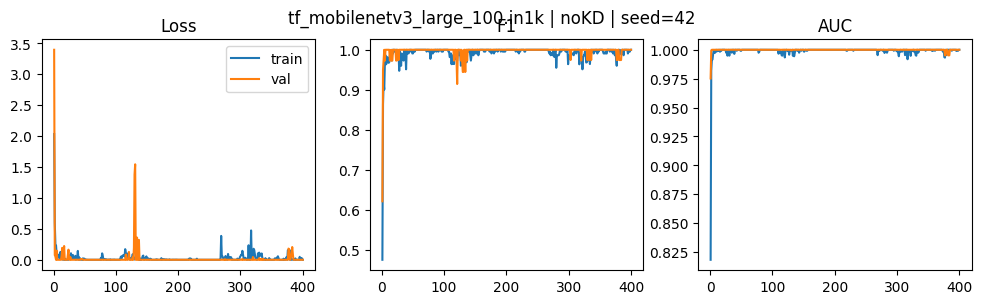

/tmp/ipykernel_683370/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.2933  F1=0.905  AUC=0.992
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[103   3]
 [  1  19]]
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]


/tmp/ipykernel_683370/3889353257.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))


[01/400] train: loss=12.1899 f1=0.297 auc=0.592 | val: loss=12.4645 f1=0.412 auc=0.764
[02/400] train: loss=6.1015 f1=0.386 auc=0.726 | val: loss=4.7364 f1=0.475 auc=0.768
[03/400] train: loss=3.4781 f1=0.503 auc=0.852 | val: loss=2.2406 f1=0.436 auc=0.813
[04/400] train: loss=1.8847 f1=0.551 auc=0.869 | val: loss=1.9048 f1=0.500 auc=0.856
[05/400] train: loss=1.3007 f1=0.542 auc=0.847 | val: loss=1.5680 f1=0.607 auc=0.897
[06/400] train: loss=0.9196 f1=0.725 auc=0.939 | val: loss=0.8937 f1=0.714 auc=0.955
[07/400] train: loss=0.6802 f1=0.732 auc=0.952 | val: loss=0.6617 f1=0.634 auc=0.916
[08/400] train: loss=0.5401 f1=0.797 auc=0.968 | val: loss=0.5580 f1=0.686 auc=0.931
[09/400] train: loss=0.4618 f1=0.798 auc=0.957 | val: loss=0.4876 f1=0.743 auc=0.942
[10/400] train: loss=0.3675 f1=0.885 auc=0.979 | val: loss=0.3717 f1=0.800 auc=0.978
[11/400] train: loss=0.3088 f1=0.860 auc=0.991 | val: loss=0.3891 f1=0.690 auc=0.976
[12/400] train: loss=0.3660 f1=0.872 auc=0.993 | val: loss=0.29

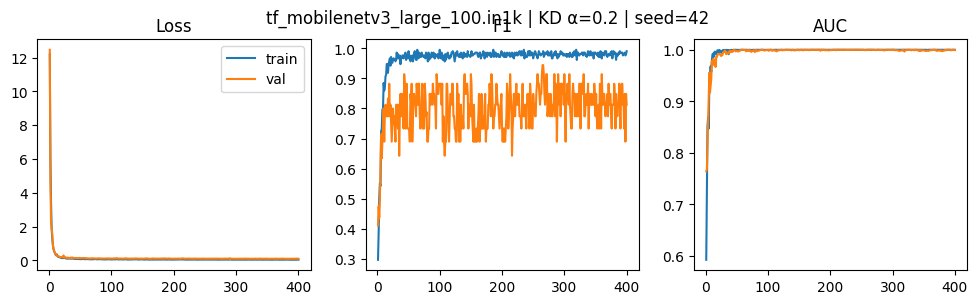

/tmp/ipykernel_683370/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.1186  F1=0.895  AUC=0.990
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[105   1]
 [  3  17]]

--------------------------------------------------------------------------------
[tf_mobilenetv3_large_100.in1k] RUN 2 / 5 | seed=43
--------------------------------------------------------------------------------
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]
[01/400] train: loss=2.4858 f1=0.453 auc=0.804 | val: loss=0.9666 f1=0.788 auc=0.989
[02/400] train: loss=0.7315 f1=0.809 auc=0.973 | val: loss=0.1872 f1=0.950 auc=0.992
[03/400] train: loss=0.3475 f1=0.919 auc=0.988 | val: loss=0.0000 f1=1.000 auc=1.000
[04/400] train: loss=0.1948 f1=0.959 auc=0.992 | val: loss=0.0015 f1=1.000 auc=1.000
[05/400] train: loss=0.0488 f1=0.952 auc=0.997 | val: loss=0.0001 f1=1.000 auc=1.000
[06/400] train: loss=0.0390 f1=0.991 auc=1.000 | val: loss=0.0000 f1=1.000 auc=1.000
[07/400] train: loss=0.1000 f1=0.981 auc=0.998 | val: loss=0.0195 f1=0.974 a

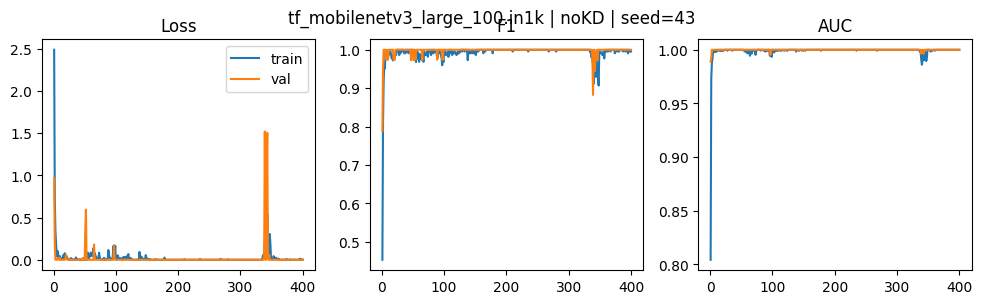

/tmp/ipykernel_683370/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.3970  F1=0.872  AUC=0.988
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[104   2]
 [  3  17]]
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]


/tmp/ipykernel_683370/3889353257.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))


[01/400] train: loss=10.5734 f1=0.314 auc=0.618 | val: loss=8.1707 f1=0.531 auc=0.842
[02/400] train: loss=7.3317 f1=0.391 auc=0.738 | val: loss=8.0307 f1=0.343 auc=0.678
[03/400] train: loss=4.2033 f1=0.529 auc=0.853 | val: loss=4.3100 f1=0.450 auc=0.754
[04/400] train: loss=2.5071 f1=0.485 auc=0.817 | val: loss=2.7681 f1=0.419 auc=0.716
[05/400] train: loss=1.5124 f1=0.606 auc=0.905 | val: loss=2.2073 f1=0.564 auc=0.767
[06/400] train: loss=1.1758 f1=0.619 auc=0.898 | val: loss=1.4662 f1=0.412 auc=0.760
[07/400] train: loss=0.9533 f1=0.644 auc=0.915 | val: loss=1.1366 f1=0.562 auc=0.857
[08/400] train: loss=0.8841 f1=0.714 auc=0.937 | val: loss=0.7672 f1=0.537 auc=0.858
[09/400] train: loss=0.6340 f1=0.683 auc=0.931 | val: loss=0.6669 f1=0.651 auc=0.928
[10/400] train: loss=0.5142 f1=0.780 auc=0.975 | val: loss=0.5056 f1=0.625 auc=0.935
[11/400] train: loss=0.5220 f1=0.783 auc=0.971 | val: loss=0.4309 f1=0.688 auc=0.940
[12/400] train: loss=0.4589 f1=0.798 auc=0.968 | val: loss=0.425

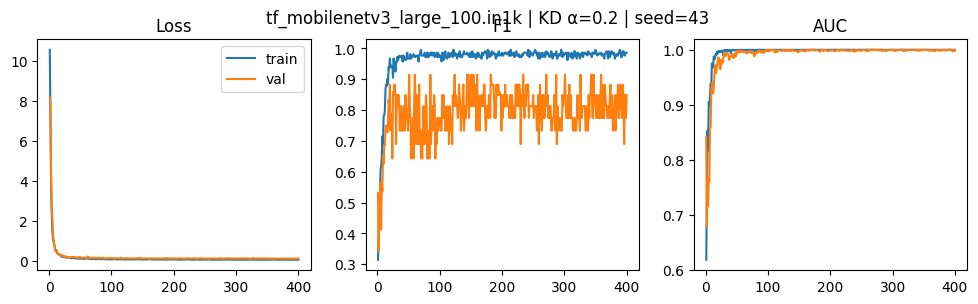

/tmp/ipykernel_683370/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.1808  F1=0.842  AUC=0.967
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[104   2]
 [  4  16]]

--------------------------------------------------------------------------------
[tf_mobilenetv3_large_100.in1k] RUN 3 / 5 | seed=44
--------------------------------------------------------------------------------
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]
[01/400] train: loss=2.4211 f1=0.430 auc=0.783 | val: loss=3.3030 f1=0.750 auc=0.967
[02/400] train: loss=0.5273 f1=0.907 auc=0.986 | val: loss=0.1766 f1=0.950 auc=0.995
[03/400] train: loss=0.2590 f1=0.882 auc=0.988 | val: loss=0.0760 f1=0.974 auc=0.998
[04/400] train: loss=0.2169 f1=0.967 auc=0.998 | val: loss=0.1825 f1=0.973 auc=1.000
[05/400] train: loss=0.1175 f1=0.955 auc=0.996 | val: loss=0.0001 f1=1.000 auc=1.000
[06/400] train: loss=0.0432 f1=0.955 auc=0.998 | val: loss=0.0006 f1=1.000 auc=1.000
[07/400] train: loss=0.0566 f1=0.972 auc=0.998 | val: loss=0.0000 f1=1.000 a

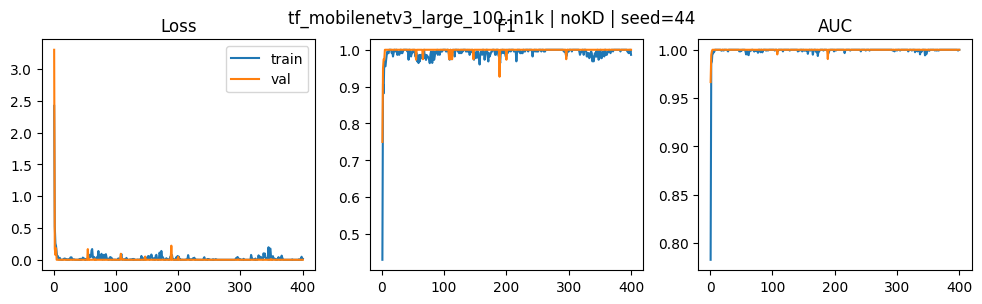

/tmp/ipykernel_683370/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.6493  F1=0.878  AUC=0.985
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[103   3]
 [  2  18]]
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]


/tmp/ipykernel_683370/3889353257.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))


[01/400] train: loss=7.8134 f1=0.350 auc=0.684 | val: loss=9.1149 f1=0.200 auc=0.566
[02/400] train: loss=7.1523 f1=0.393 auc=0.711 | val: loss=6.8751 f1=0.531 auc=0.810
[03/400] train: loss=4.1006 f1=0.475 auc=0.831 | val: loss=2.6737 f1=0.340 auc=0.723
[04/400] train: loss=1.9388 f1=0.553 auc=0.869 | val: loss=1.5347 f1=0.583 auc=0.875
[05/400] train: loss=1.2274 f1=0.587 auc=0.898 | val: loss=1.1612 f1=0.681 auc=0.943
[06/400] train: loss=0.7832 f1=0.710 auc=0.939 | val: loss=0.8485 f1=0.562 auc=0.898
[07/400] train: loss=0.6429 f1=0.750 auc=0.947 | val: loss=0.7045 f1=0.696 auc=0.964
[08/400] train: loss=0.4824 f1=0.802 auc=0.970 | val: loss=0.5098 f1=0.706 auc=0.942
[09/400] train: loss=0.4154 f1=0.817 auc=0.969 | val: loss=0.4249 f1=0.780 auc=0.958
[10/400] train: loss=0.3752 f1=0.856 auc=0.987 | val: loss=0.3410 f1=0.750 auc=0.966
[11/400] train: loss=0.2969 f1=0.896 auc=0.987 | val: loss=0.3616 f1=0.889 auc=0.973
[12/400] train: loss=0.2952 f1=0.887 auc=0.988 | val: loss=0.3108

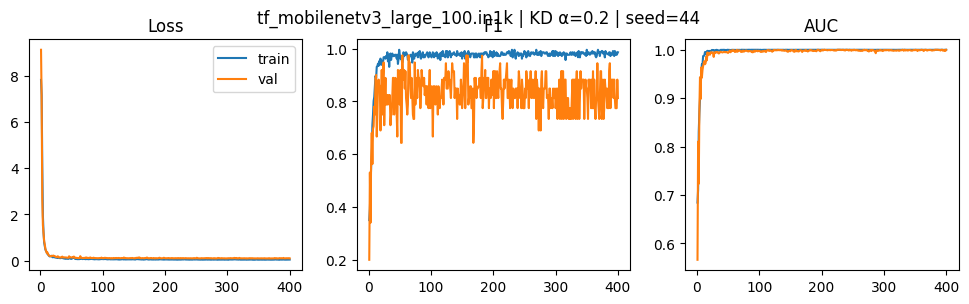

/tmp/ipykernel_683370/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.1409  F1=0.821  AUC=0.987
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[103   3]
 [  4  16]]

--------------------------------------------------------------------------------
[tf_mobilenetv3_large_100.in1k] RUN 4 / 5 | seed=45
--------------------------------------------------------------------------------
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]
[01/400] train: loss=2.8748 f1=0.423 auc=0.763 | val: loss=0.3246 f1=0.878 auc=0.988
[02/400] train: loss=0.9792 f1=0.724 auc=0.954 | val: loss=0.1983 f1=0.923 auc=0.992
[03/400] train: loss=0.1866 f1=0.962 auc=0.999 | val: loss=0.1521 f1=0.973 auc=0.998
[04/400] train: loss=0.1285 f1=0.934 auc=0.994 | val: loss=0.0014 f1=1.000 auc=1.000
[05/400] train: loss=0.0560 f1=0.973 auc=0.997 | val: loss=0.2752 f1=0.973 auc=0.999
[06/400] train: loss=0.1240 f1=0.991 auc=0.995 | val: loss=0.2900 f1=0.973 auc=1.000
[07/400] train: loss=0.0100 f1=0.986 auc=1.000 | val: loss=0.0234 f1=0.974 a

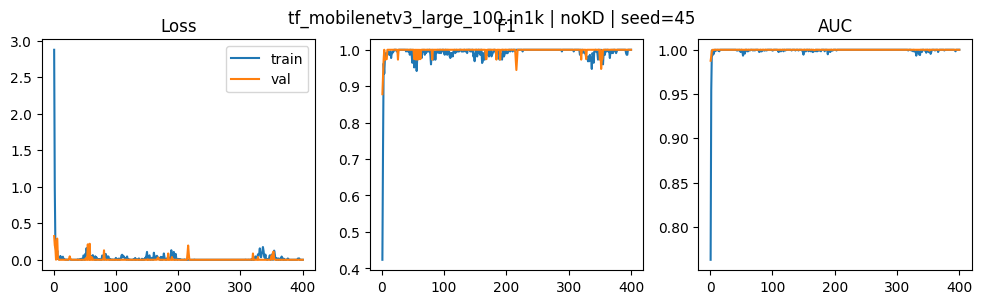

/tmp/ipykernel_683370/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.4803  F1=0.829  AUC=0.993
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[102   4]
 [  3  17]]
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]


/tmp/ipykernel_683370/3889353257.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))


[01/400] train: loss=7.5259 f1=0.344 auc=0.673 | val: loss=9.0416 f1=0.373 auc=0.747
[02/400] train: loss=6.3015 f1=0.397 auc=0.738 | val: loss=5.2719 f1=0.423 auc=0.735
[03/400] train: loss=3.4367 f1=0.514 auc=0.839 | val: loss=3.1990 f1=0.508 auc=0.885
[04/400] train: loss=2.0076 f1=0.487 auc=0.823 | val: loss=1.5718 f1=0.533 auc=0.880
[05/400] train: loss=1.2895 f1=0.649 auc=0.924 | val: loss=1.5825 f1=0.632 auc=0.899
[06/400] train: loss=0.8242 f1=0.659 auc=0.920 | val: loss=0.9050 f1=0.653 auc=0.955
[07/400] train: loss=0.5764 f1=0.730 auc=0.956 | val: loss=0.6341 f1=0.800 auc=0.961
[08/400] train: loss=0.3887 f1=0.866 auc=0.987 | val: loss=0.4813 f1=0.833 auc=0.981
[09/400] train: loss=0.3542 f1=0.838 auc=0.978 | val: loss=0.3750 f1=0.645 auc=0.970
[10/400] train: loss=0.3028 f1=0.816 auc=0.979 | val: loss=0.4602 f1=0.923 auc=0.995
[11/400] train: loss=0.2962 f1=0.914 auc=0.993 | val: loss=0.3246 f1=0.800 auc=0.991
[12/400] train: loss=0.2456 f1=0.914 auc=0.991 | val: loss=0.2927

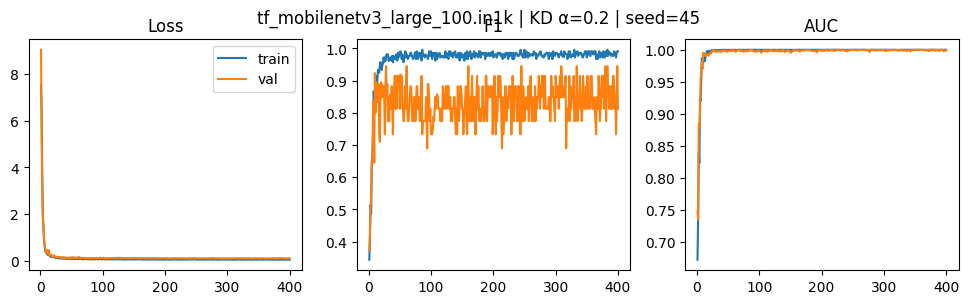

/tmp/ipykernel_683370/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.1545  F1=0.829  AUC=0.967
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[102   4]
 [  3  17]]

--------------------------------------------------------------------------------
[tf_mobilenetv3_large_100.in1k] RUN 5 / 5 | seed=46
--------------------------------------------------------------------------------
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]
[01/400] train: loss=2.6698 f1=0.420 auc=0.781 | val: loss=0.5767 f1=0.944 auc=0.995
[02/400] train: loss=0.3662 f1=0.862 auc=0.982 | val: loss=0.0088 f1=1.000 auc=1.000
[03/400] train: loss=0.0976 f1=0.934 auc=0.996 | val: loss=0.0321 f1=0.973 auc=1.000
[04/400] train: loss=0.1657 f1=0.953 auc=0.998 | val: loss=0.0553 f1=0.973 auc=1.000
[05/400] train: loss=0.0706 f1=0.951 auc=0.996 | val: loss=0.0000 f1=1.000 auc=1.000
[06/400] train: loss=0.0761 f1=0.934 auc=0.997 | val: loss=0.2296 f1=0.973 auc=1.000
[07/400] train: loss=0.0912 f1=0.991 auc=0.995 | val: loss=0.0000 f1=1.000 a

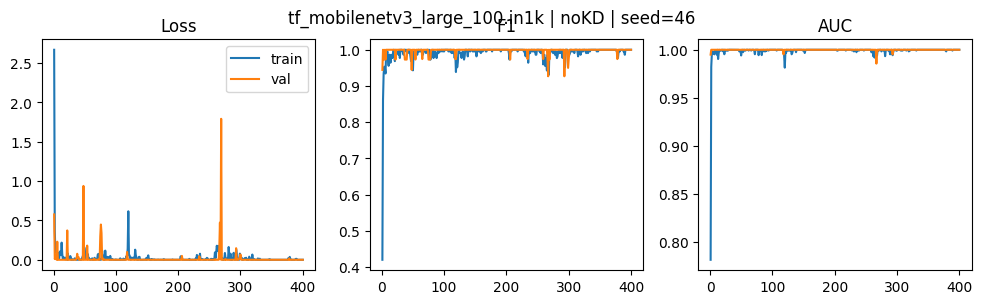

/tmp/ipykernel_683370/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.5551  F1=0.905  AUC=0.987
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[103   3]
 [  1  19]]
class counts: {0: 591, 1: 108} | class weights: [0.5913705825805664, 3.2361111640930176]


/tmp/ipykernel_683370/3889353257.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load(cfg.teacher_ckpt, map_location=device))


[01/400] train: loss=8.4959 f1=0.338 auc=0.656 | val: loss=7.9998 f1=0.367 auc=0.749
[02/400] train: loss=7.2104 f1=0.392 auc=0.743 | val: loss=5.5434 f1=0.500 auc=0.824
[03/400] train: loss=4.3963 f1=0.430 auc=0.809 | val: loss=3.1332 f1=0.410 auc=0.656
[04/400] train: loss=2.2078 f1=0.519 auc=0.844 | val: loss=1.9116 f1=0.453 auc=0.745
[05/400] train: loss=1.4337 f1=0.572 auc=0.890 | val: loss=1.1192 f1=0.511 auc=0.856
[06/400] train: loss=0.9783 f1=0.686 auc=0.940 | val: loss=0.9948 f1=0.558 auc=0.818
[07/400] train: loss=0.8135 f1=0.662 auc=0.924 | val: loss=0.6438 f1=0.686 auc=0.872
[08/400] train: loss=0.5541 f1=0.715 auc=0.951 | val: loss=0.5691 f1=0.629 auc=0.815
[09/400] train: loss=0.4921 f1=0.800 auc=0.966 | val: loss=0.5783 f1=0.651 auc=0.900
[10/400] train: loss=0.4393 f1=0.814 auc=0.971 | val: loss=0.4514 f1=0.774 auc=0.918
[11/400] train: loss=0.3295 f1=0.873 auc=0.988 | val: loss=0.4139 f1=0.765 auc=0.929
[12/400] train: loss=0.3102 f1=0.883 auc=0.990 | val: loss=0.3540

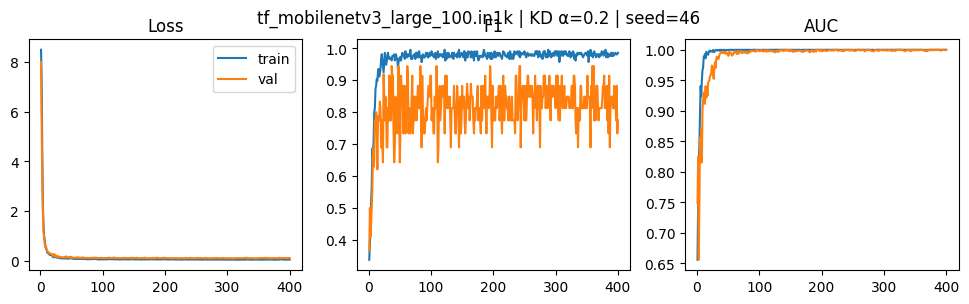

/tmp/ipykernel_683370/1254553406.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=device))


[TEST] loss=0.1345  F1=0.800  AUC=0.987
Confusion Matrix (thr=0.5)
[[TN FP]
 [FN TP]]
 [[102   4]
 [  4  16]]


,model,mode,alpha,seed,repeat_idx,best_val_auc,test_loss,test_f1,test_auc,tn,fp,fn,tp,ckpt_path
0,tf_mobilenetv3_large_100.in1k,noKD,NaN,42,0,1.000000,0.293270,0.904762,0.991509,103,3,1,19,experiments/repeats/tf_mobilenetv3_large_100_i...
1,tf_mobilenetv3_large_100.in1k,KD,0.2,42,0,0.944444,0.118574,0.894737,0.989623,105,1,3,17,experiments/repeats/tf_mobilenetv3_large_100_i...
2,tf_mobilenetv3_large_100.in1k,noKD,NaN,43,1,1.000000,0.397030,0.871795,0.987972,104,2,3,17,experiments/repeats/tf_mobilenetv3_large_100_i...
3,tf_mobilenetv3_large_100.in1k,KD,0.2,43,1,0.914286,0.180812,0.842105,0.966981,104,2,4,16,experiments/repeats/tf_mobilenetv3_large_100_i...
4,tf_mobilenetv3_large_100.in1k,noKD,NaN,44,2,1.000000,0.649343,0.878049,0.984906,103,3,2,18,experiments/repeats/tf_mobilenetv3_large_100_i...
5,tf_mobilenetv3_large_100.in1k,KD,0.2,44,2,0.974359,0.140912,0.820513,0.987264,103,3,4,16,experiments/repeats/tf_mobilenetv3_large_100_i...
6,tf_mobilenetv3_large_100.in1k,noKD,NaN,45,3,1.000000,0.480310,0.829268,0.992925,102,4,3,17,experiments/repeats/tf_mobilenetv3_large_100_i...
7,tf_mobilenetv3_large_100.in1k,KD,0.2,45,3,0.944444,0.154525,0.829268,0.966509,102,4,3,17,experiments/repeats/tf_mobilenetv3_large_100_i...
8,tf_mobilenetv3_large_100.in1k,noKD,NaN,46,4,1.000000,0.555119,0.904762,0.987028,103,3,1,19,experiments/repeats/tf_mobilenetv3_large_100_i...
9,tf_mobilenetv3_large_100.in1k,KD,0.2,46,4,0.944444,0.134524,0.800000,0.986792,102,4,4,16,experiments/repeats/tf_mobilenetv3_large_100_i...


test_f1            test_auc  \
                                              mean       std      mean   
model                         mode alpha                                 
tf_mobilenetv3_large_100.in1k KD   0.2    0.837325  0.035566  0.979434   
                              noKD NaN    0.877727  0.031005  0.988868   

                                                   best_val_auc            \
                                               std         mean       std   
model                         mode alpha                                    
tf_mobilenetv3_large_100.in1k KD   0.2    0.011634     0.944396  0.021239   
                              noKD NaN    0.003291     1.000000  0.000000   

                                             tn             fp             fn  \
                                           mean       std mean       std mean   
model                         mode alpha                                        
tf_mobilenetv3_large_100.in1k KD   0.2    103.2  1.303840  2.8  1.303840  3.6   
                              noKD NaN    103.0  0.707107  3.0  0.707107  2.0   

                                                      tp            
                                               std  mean       std  
model                         mode alpha                            
tf_mobilenetv3_large_100.in1k KD   0.2    0.547723  16.4  0.547723  
                              noKD NaN    1.000000  18.0  1.000000

In [41]:
# student_candidates = [
#     ("tf_efficientnet_lite0.in1k",        224, 64),
#     ("tf_efficientnet_lite2.in1k",        260, 48),
#     ("tf_mobilenetv3_small_100.in1k",     224, 96),
#     ("tf_mobilenetv3_large_100.in1k",     224, 64),
#     ("mobilenetv3_large_100.ra_in1k",     224, 64),
# ]

BEST_ALPHA_PER_STUDENT = {
    "tf_mobilenetv3_large_100.in1k": 0.2,
    "tf_efficientnet_lite0.in1k": 0.2,
    "tf_efficientnet_lite2.in1k": 0.2,
    "tf_mobilenetv3_small_100.in1k": 0.2,
    "mobilenetv3_large_100.ra_in1k": 0.2
}

RUN_SEEDS = [42, 43, 44, 45, 46]

def make_loaders_for_student(student_name: str, img_sz: int, bs: int):
    full_rows = splits["train"] + splits["val"]

    train_tf_full, val_tf_full = build_transforms(img_sz, cfg.robust_aug)

    ds_full = RowsDataset(full_rows, train_tf_full)
    dl_full = DataLoader(
        ds_full,
        batch_size=bs,
        shuffle=True,
        num_workers=cfg.num_workers,
        pin_memory=True
    )

    ds_val_student = RowsDataset(splits["val"], val_tf_full)
    val_dl_student = DataLoader(
        ds_val_student,
        batch_size=bs,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=True
    )

    test_tf_student = T.Compose([
        T.Resize((img_sz, img_sz)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    test_ds_student = CSVDataset(cfg.test_csv, transform=test_tf_student)
    test_dl_student = DataLoader(
        test_ds_student,
        batch_size=bs,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=True
    )

    return dl_full, val_dl_student, test_dl_student

def make_cfg_for_run(base_cfg: TrainConfig,
                     student_name: str,
                     out_dir: str,
                     img_sz: int,
                     bs: int,
                     use_distill: bool,
                     alpha: float,
                     seed: int):
    return TrainConfig(
        train_csv            = base_cfg.train_csv,
        val_csv              = base_cfg.val_csv,
        test_csv             = base_cfg.test_csv,
        img_size             = img_sz,
        robust_aug           = base_cfg.robust_aug,
        batch_size           = bs,
        num_workers          = base_cfg.num_workers,
        use_class_weight     = True,
        use_weighted_sampler = False,
        epochs               = base_cfg.epochs,
        lr                   = base_cfg.lr,
        weight_decay         = base_cfg.weight_decay,
        early_stop_patience  = base_cfg.early_stop_patience,
        seed                 = seed,
        amp                  = base_cfg.amp,
        model_name           = student_name,
        num_classes          = base_cfg.num_classes,
        use_distill          = use_distill,
        teacher_ckpt         = base_cfg.teacher_ckpt,
        distill_alpha        = alpha,
        distill_T            = base_cfg.distill_T,
        out_dir              = out_dir,
        save_best_name       = "best_student.pt",
    )

all_results = []

for (student_name, img_sz, bs) in student_candidates:
    print("\n" + "#"*90)
    print("STUDENT:", student_name, "| img_sz:", img_sz, "| batch_size:", bs)
    print("#"*90)

    dl_full, val_dl_student, test_dl_student = make_loaders_for_student(student_name, img_sz, bs)

    alpha_best = BEST_ALPHA_PER_STUDENT.get(student_name, cfg.distill_alpha)

    for rep_idx, seed in enumerate(RUN_SEEDS):
        print("\n" + "-"*80)
        print(f"[{student_name}] RUN {rep_idx+1} / {len(RUN_SEEDS)} | seed={seed}")
        print("-"*80)

        out_dir_no_kd = os.path.join(
            "experiments",
            "repeats",
            student_name.replace(".", "_"),
            f"noKD",
            f"seed_{seed}"
        )
        cfg_no_kd = make_cfg_for_run(
            cfg,
            student_name=student_name,
            out_dir=out_dir_no_kd,
            img_sz=img_sz,
            bs=bs,
            use_distill=False,
            alpha=alpha_best,
            seed=seed,
        )

        best_ckpt_no_kd, best_val_auc_no_kd = train_model_with_loaders(
            cfg_no_kd, dl_full, val_dl_student,
            verbose=1,
            log_csv=True
        )

        plot_run_curves(cfg_no_kd.out_dir,
                        title=f"{student_name} | noKD | seed={seed}")

        test_loss, test_f1, test_auc, cm = quick_test_eval(
            best_ckpt_no_kd,
            cfg_no_kd.model_name,
            test_dl_student
        )

        all_results.append({
            "model": student_name,
            "mode": "noKD",
            "alpha": None,
            "seed": seed,
            "repeat_idx": rep_idx,
            "best_val_auc": best_val_auc_no_kd,
            "test_loss": test_loss,
            "test_f1": test_f1,
            "test_auc": test_auc,
            "tn": int(cm[0,0]),
            "fp": int(cm[0,1]),
            "fn": int(cm[1,0]),
            "tp": int(cm[1,1]),
            "ckpt_path": best_ckpt_no_kd,
        })

        out_dir_kd = os.path.join(
            "experiments",
            "repeats",
            student_name.replace(".", "_"),
            f"KD_alpha{str(alpha_best).replace('.','_')}",
            f"seed_{seed}"
        )

        cfg_kd = make_cfg_for_run(
            cfg,
            student_name=student_name,
            out_dir=out_dir_kd,
            img_sz=img_sz,
            bs=bs,
            use_distill=True,
            alpha=alpha_best,
            seed=seed,
        )

        best_ckpt_kd, best_val_auc_kd = train_model_with_loaders(
            cfg_kd, dl_full, val_dl_student,
            verbose=1,
            log_csv=True
        )

        plot_run_curves(cfg_kd.out_dir,
                        title=f"{student_name} | KD α={alpha_best} | seed={seed}")

        test_loss, test_f1, test_auc, cm = quick_test_eval(
            best_ckpt_kd,
            cfg_kd.model_name,
            test_dl_student
        )

        all_results.append({
            "model": student_name,
            "mode": "KD",
            "alpha": float(alpha_best),
            "seed": seed,
            "repeat_idx": rep_idx,
            "best_val_auc": best_val_auc_kd,
            "test_loss": test_loss,
            "test_f1": test_f1,
            "test_auc": test_auc,
            "tn": int(cm[0,0]),
            "fp": int(cm[0,1]),
            "fn": int(cm[1,0]),
            "tp": int(cm[1,1]),
            "ckpt_path": best_ckpt_kd,
        })

os.makedirs("experiments/summary", exist_ok=True)
df_results = pd.DataFrame(all_results)
df_results.to_csv("experiments/summary/repeats_results.csv", index=False)
display(df_results)

summary = (
    df_results
    .groupby(["model","mode","alpha"], dropna=False)[["test_f1","test_auc","best_val_auc","tn","fp","fn","tp"]]
    .agg(["mean","std"])
)
display(summary)


In [42]:
summary = (
    df_results
    .groupby(["model","mode","alpha"], dropna=False)[["test_f1","test_auc","test_loss"]]
    .agg(["mean","std"])
)
display(summary)

test_f1            test_auc  \
                                              mean       std      mean   
model                         mode alpha                                 
tf_mobilenetv3_large_100.in1k KD   0.2    0.837325  0.035566  0.979434   
                              noKD NaN    0.877727  0.031005  0.988868   

                                                   test_loss            
                                               std      mean       std  
model                         mode alpha                                
tf_mobilenetv3_large_100.in1k KD   0.2    0.011634  0.145869  0.023421  
                              noKD NaN    0.003291  0.475014  0.137793

In [43]:
def plot_run_curves(run_dir, title=None):
    csv_path = os.path.join(run_dir, "train_log.csv")
    if not os.path.exists(csv_path):
        print("missing:", csv_path); return
    df = pd.read_csv(csv_path)
    fig,ax = plt.subplots(1,3,figsize=(12,3))
    ax[0].plot(df.epoch, df.tr_loss, label="train"); ax[0].plot(df.epoch, df.va_loss, label="val")
    ax[0].set_title("Loss"); ax[0].legend()
    ax[1].plot(df.epoch, df.tr_f1, label="train"); ax[1].plot(df.epoch, df.va_f1, label="val")
    ax[1].set_title("F1")
    ax[2].plot(df.epoch, df.tr_auc, label="train"); ax[2].plot(df.epoch, df.va_auc, label="val")
    ax[2].set_title("AUC")
    if title: fig.suptitle(title)
    plt.show()

In [44]:
plt.figure(figsize=(7,4))
plt.bar(df_summary["model"], df_summary["mean_auc"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean AUC (CV)")
plt.title("CV Mean AUC by Candidate")
plt.tight_layout(); plt.show()

NameError: name 'df_summary' is not defined

<Figure size 700x400 with 0 Axes>

In [ ]:
models = sorted(df_perfold["model"].unique())
data = [df_perfold[df_perfold["model"]==m]["val_auc"].values for m in models]

plt.figure(figsize=(7,4))
plt.boxplot(data, labels=models, showmeans=True)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Val AUC"); plt.title("Per-fold AUC distribution")
plt.tight_layout(); plt.show()

In [ ]:
import os
print(cfg_final.out_dir)
log_path = os.path.join(cfg_final.out_dir, "train_log.csv")
if os.path.exists(log_path):
    logdf = pd.read_csv(log_path)
    plt.figure(figsize=(6,4))
    plt.plot(logdf["epoch"], logdf["tr_auc"], label="train AUC")
    plt.plot(logdf["epoch"], logdf["va_auc"], label="val AUC")
    plt.xlabel("epoch"); plt.ylabel("AUC"); plt.title("Training curve (final)")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(logdf["epoch"], logdf["tr_f1"], label="train F1")
    plt.plot(logdf["epoch"], logdf["va_f1"], label="val F1")
    plt.xlabel("epoch"); plt.ylabel("F1"); plt.title("Training curve (final)")
    plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc as sk_auc
import numpy as np, torch

model = create_model(cfg_final.model_name, 2).to(device)
model.load_state_dict(torch.load(best_ckpt, map_location=device)); model.eval()

y_prob, y_true = [], []
with torch.no_grad():
    for x, y in test_dl_student:
        x = x.to(device)
        p = torch.softmax(model(x), dim=1)[:,1].detach().cpu().numpy()
        y_prob.append(p); y_true.append(y.numpy())
y_prob = np.concatenate(y_prob); y_true = np.concatenate(y_true)

# ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = sk_auc(fpr, tpr)
plt.figure(figsize=(5,4)); plt.plot(fpr, tpr, label=f"ROC AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (test)")
plt.legend(); plt.tight_layout(); plt.show()

# PR
prec, rec, _ = precision_recall_curve(y_true, y_prob)
pr_auc = sk_auc(rec, prec)
plt.figure(figsize=(5,4)); plt.plot(rec, prec, label=f"PR AUC={pr_auc:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR (test)")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
def collect_probs_labels(ckpt_path, arch_name, dataloader):
    model = create_model(arch_name, 2).to(device)
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.eval()
    probs=[]; labels=[]
    with torch.no_grad():
        for x,y in dataloader:
            x = x.to(device); 
            p = torch.softmax(model(x), dim=1)[:,1].detach().cpu().numpy()
            probs.append(p); labels.append(y.numpy())
    return np.concatenate(probs), np.concatenate(labels)

In [ ]:
def plot_roc_pr(y_true, y_prob, title=""):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = sk_auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = np.trapz(prec, rec)

    fig = plt.figure(figsize=(11,4))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
    plt.title(f"ROC AUC = {roc_auc:.3f}"); plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.subplot(1,2,2)
    plt.plot(rec, prec)
    plt.title(f"PR curve (area ≈ {pr_auc:.3f})"); plt.xlabel("Recall"); plt.ylabel("Precision")
    fig.suptitle(title)
    plt.show()

In [ ]:
def find_best_f1_threshold(y_true, y_prob):
    thr_list = np.linspace(0.05, 0.95, 37)
    best = (0.5, -1.0)
    for thr in thr_list:
        f1 = f1_score(y_true, (y_prob>=thr).astype(int))
        if f1 > best[1]: best = (thr, f1)
    return best

In [ ]:
def show_confusion(y_true, y_prob, thr=0.5, title=""):
    y_hat = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_hat, labels=[0,1])
    fig = plt.figure(figsize=(3,3))
    plt.imshow(cm, cmap="Blues"); plt.title(title)
    plt.xticks([0,1],["Pred Safe","Pred Viol"]); plt.yticks([0,1],["True Safe","True Viol"])
    for i in range(2):
        for j in range(2):
            plt.text(j,i,str(cm[i,j]), ha='center', va='center')
    plt.show()
    return cm

In [ ]:
teacher_arch = "tf_efficientnetv2_l"
teacher_ckpt = "models/server/best_server.pt"
yprob_te, ytrue_te = collect_probs_labels(teacher_ckpt, teacher_arch, test_dl)
plot_roc_pr(ytrue_te, yprob_te, title="TEACHER")
thr_te, bestf1_te = find_best_f1_threshold(ytrue_te, yprob_te)
print("Teacher best-F1 thr:", round(thr_te,2), "F1=", round(bestf1_te,3))
_ = show_confusion(ytrue_te, yprob_te, thr=0.5, title="Teacher CM @0.5")
_ = show_confusion(ytrue_te, yprob_te, thr=thr_te, title=f"Teacher CM @thr={thr_te:.2f}")

In [ ]:
best_student_arch = cfg_final.model_name
best_student_ckpt = best_ckpt
print("Best student:", best_student_arch)
print("Checkpoint path:", best_student_ckpt)

In [ ]:
yprob_st, ytrue_st = collect_probs_labels(best_student_ckpt, best_student_arch, test_dl_student) 
plot_roc_pr(ytrue_st, yprob_st, title=f"STUDENT: {best_student_arch}")
thr_st, bestf1_st = find_best_f1_threshold(ytrue_st, yprob_st)
print("Student best-F1 thr:", round(thr_st,2), "F1=", round(bestf1_st,3))
_ = show_confusion(ytrue_st, yprob_st, thr=0.5, title="Student CM @0.5")
_ = show_confusion(ytrue_st, yprob_st, thr=thr_st, title=f"Student CM @thr={thr_st:.2f}")

plot_roc_pr(ytrue_st, yprob_st, title=f"STUDENT: {best_student_arch}")
thr_st, bestf1_st = find_best_f1_threshold(ytrue_st, yprob_st)
print("Student best-F1 thr:", round(thr_st,2), "F1=", round(bestf1_st,3))
_ = show_confusion(ytrue_st, yprob_st, thr=0.5, title="Student CM @0.5")
_ = show_confusion(ytrue_st, yprob_st, thr=thr_st, title=f"Student CM @thr={thr_st:.2f}")

In [ ]:
df = score_kd.copy()
fig=plt.figure(figsize=(6,4))
plt.scatter(df["test_auc"], df["latency_ms_1x"])
for _,r in df.iterrows():
    plt.annotate(r["model"], (r["test_auc"], r["latency_ms_1x"]), fontsize=8, xytext=(2,2), textcoords="offset points")
plt.xlabel("Test AUC (higher better)")
plt.ylabel("Latency per image (ms, lower better)")
plt.title("Accuracy vs Latency (students)")
plt.grid(True, ls="--", alpha=.4)
plt.show()

In [ ]:
# ARCH_STUDENT = "tf_efficientnet_lite2" 
# NUM_CLASSES  = 2
# IMG_SIZE     = 224

# CKPT_STUDENT = "models/client/best_student.pt"
# EXPORT_DIR   = "export_tflite"
# LABELS_TXT   = f"{EXPORT_DIR}/labels.txt"

# DATA_TRAIN_DIR = "data/train"


In [ ]:
# !pip install -q onnx onnxsim onnx-tf

# import os, io, random, numpy as np
# import torch, timm
# from PIL import Image

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

# model_student = timm.create_model(
#     ARCH_STUDENT, pretrained=False, num_classes=NUM_CLASSES
# ).to(device)

# sd = torch.load(CKPT_STUDENT, map_location=device)
# state_dict = sd.get("state_dict", sd.get("model", sd))
# if state_dict is None:
#     state_dict = sd
# model_student.load_state_dict(state_dict, strict=True)
# model_student.eval()

# print("Loaded:", ARCH_STUDENT, "classes:", NUM_CLASSES)

In [ ]:
# os.makedirs(EXPORT_DIR, exist_ok=True)
# ONNX_RAW = f"{EXPORT_DIR}/student_raw.onnx"
# ONNX_SIM = f"{EXPORT_DIR}/student_sim.onnx"

# dummy = torch.randn(1, 3, IMG_SIZE, IMG_SIZE, device=device)

# torch.onnx.export(
#     model_student, dummy, ONNX_RAW,
#     input_names=["input"], output_names=["logits"],
#     opset_version=13, do_constant_folding=True, dynamic_axes=None
# )

# print("ONNX saved:", ONNX_RAW)

In [ ]:
# import onnx
# from onnxsim import simplify

# model_onnx = onnx.load(ONNX_RAW)
# model_simplified, check = simplify(model_onnx)
# assert check, "Simplified ONNX model could not be validated"
# onnx.save(model_simplified, ONNX_SIM)
# print("ONNX simplified saved:", ONNX_SIM)

In [ ]:
# from onnx_tf.backend import prepare

# model_onnx = onnx.load(ONNX_SIM)
# tf_rep = prepare(model_onnx)  # konversi ke representasi TF
# TF_SAVED_DIR = f"{EXPORT_DIR}/tf_saved"
# if os.path.exists(TF_SAVED_DIR):
#     import shutil; shutil.rmtree(TF_SAVED_DIR)

# tf_rep.export_graph(TF_SAVED_DIR)
# print("TF SavedModel:", TF_SAVED_DIR)

In [ ]:
# import tensorflow as tf
# import pathlib, itertools

# TFL_FP32 = f"{EXPORT_DIR}/student_fp32.tflite"
# TFL_FP16 = f"{EXPORT_DIR}/student_fp16.tflite"
# TFL_INT8 = f"{EXPORT_DIR}/student_int8.tflite"

# # FP32 (baseline)
# conv = tf.lite.TFLiteConverter.from_saved_model(TF_SAVED_DIR)
# tfl32 = conv.convert()
# open(TFL_FP32, "wb").write(tfl32)

# # FP16 (disarankan: kecil, cepat, akurasi hampir sama)
# conv = tf.lite.TFLiteConverter.from_saved_model(TF_SAVED_DIR)
# conv.optimizations = [tf.lite.Optimize.DEFAULT]
# conv.target_spec.supported_types = [tf.float16]
# tfl16 = conv.convert()
# open(TFL_FP16, "wb").write(tfl16)

# # INT8 (paling kecil; butuh representative dataset)
# # Kita sampling beberapa gambar dari train_dir, lakukan preprocessing ImageNet (sesuai training)
# def representative_dataset_gen(folder=DATA_TRAIN_DIR, samples=100):
#     import os, random
#     from PIL import Image
#     paths = []
#     for cls in os.listdir(folder):
#         cpath = os.path.join(folder, cls)
#         if os.path.isdir(cpath):
#             for p in os.listdir(cpath):
#                 if p.lower().endswith((".jpg",".jpeg",".png")):
#                     paths.append(os.path.join(cpath, p))
#     random.shuffle(paths)
#     paths = paths[:samples]

#     mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)[None,None,:]
#     std  = np.array([0.229, 0.224, 0.225], dtype=np.float32)[None,None,:]

#     for p in paths:
#         img = Image.open(p).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
#         x = np.array(img, dtype=np.float32) / 255.0
#         x = (x - mean) / std
#         x = np.expand_dims(x, axis=0)  # [1,H,W,3] karena TF SavedModel biasanya NHWC
#         # Beberapa converter expect NCHW; jika perlu, transpose ke NCHW:
#         # x = np.transpose(x, (0,3,1,2))
#         yield [x]

# try:
#     conv = tf.lite.TFLiteConverter.from_saved_model(TF_SAVED_DIR)
#     conv.optimizations = [tf.lite.Optimize.DEFAULT]
#     conv.representative_dataset = lambda: representative_dataset_gen(DATA_TRAIN_DIR, 100)
#     # Mode int8 “full integer” jika memungkinkan:
#     conv.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#     # Tipe input/output (bisa uint8 atau int8 tergantung preferensi):
#     conv.inference_input_type = tf.float32  # sering lebih aman; biarkan float32 supaya preprocessing tetap float
#     conv.inference_output_type = tf.float32
#     tfl8 = conv.convert()
#     open(TFL_INT8, "wb").write(tfl8)
#     print("INT8 TFLite created.")
# except Exception as e:
#     print("INT8 conversion skipped due to:", e)

# print("TFLite ready:", TFL_FP32, TFL_FP16, "(and possibly)", TFL_INT8)

In [ ]:
# # Ambil satu gambar uji
# TEST_IMG = "data/val/violence/xxx.jpg"   # ganti satu file nyata

# # Preprocess (PyTorch)
# def preprocess_pt(pil):
#     x = np.array(pil.resize((IMG_SIZE, IMG_SIZE)), dtype=np.float32)/255.0
#     x = (x - np.array([0.485,0.456,0.406])) / np.array([0.229,0.224,0.225])
#     x = np.transpose(x, (2,0,1))  # CHW
#     x = torch.from_numpy(x).unsqueeze(0).to(device)
#     return x

# # Preprocess (TF/TFLite) NHWC
# def preprocess_tf(pil):
#     x = np.array(pil.resize((IMG_SIZE, IMG_SIZE)), dtype=np.float32)/255.0
#     x = (x - np.array([0.485,0.456,0.406])) / np.array([0.229,0.224,0.225])
#     x = np.expand_dims(x, 0)  # NHWC
#     return x

# from scipy.special import softmax
# pil = Image.open(TEST_IMG).convert("RGB")

# # PyTorch logits -> prob
# with torch.no_grad():
#     pt_in = preprocess_pt(pil)
#     pt_logits = model_student(pt_in).cpu().numpy()
#     pt_prob = softmax(pt_logits, axis=1)[0]
# print("PyTorch prob:", pt_prob)

# # TFLite (FP16) inference
# import tensorflow as tf
# interpreter = tf.lite.Interpreter(model_path=TFL_FP16)
# interpreter.allocate_tensors()
# inp = interpreter.get_input_details()[0]
# out = interpreter.get_output_details()[0]

# tf_in = preprocess_tf(pil).astype(np.float32)

# # Jika input shape butuh NCHW (jarang), transpose di sini.
# interpreter.set_tensor(inp['index'], tf_in)
# interpreter.invoke()
# tfl_logits = interpreter.get_tensor(out['index'])
# tfl_prob = softmax(tfl_logits, axis=1)[0]
# print("TFLite prob:", tfl_prob)

In [ ]:
# with open(LABELS_TXT, "w") as f:
#     f.write("safe\nviolence\n")
# print("Labels saved:", LABELS_TXT)

In [ ]:
# from PIL import Image
# import torch, numpy as np
# import torchvision.transforms as T

# @torch.inference_mode()
# def predict_image(ckpt_path: str,
#                   arch_name: str,
#                   img_path: str,
#                   img_size: int = 224,
#                   threshold: float = 0.5):

#     model = create_model(arch_name, num_classes=2, pretrained=False).to(device)
#     sd = torch.load(ckpt_path, map_location=device)
#     model.load_state_dict(sd)
#     model.eval()

#     # preprocessing (samakan dengan val_tf kamu)
#     tf = T.Compose([
#         T.Resize((img_size, img_size)),
#         T.ToTensor(),
#         T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
#     ])

#     # open image
#     img = Image.open(img_path).convert("RGB")
#     x = tf(img).unsqueeze(0).to(device)  # [1,3,H,W]

#     # forward
#     logits = model(x)
#     prob = torch.softmax(logits, dim=1)[0,1].item()  # prob kelas 1 = "Violence"
#     pred = int(prob >= threshold)

#     return {
#         "path": img_path,
#         "arch": arch_name,
#         "checkpoint": ckpt_path,
#         "img_size": img_size,
#         "prob_violence": float(prob),
#         "pred_label": pred,  # 1 = Violence, 0 = Safe
#         "threshold": threshold,
#     }

# res_teacher = predict_image(
#     ckpt_path="models/server/best_server.pt",
#     arch_name="tf_efficientnetv2_l", 
#     img_path="tes3.jpg",
#     img_size=320, 
#     threshold=0.5
# )
# print(res_teacher)

# res_student = predict_image(
#     ckpt_path="experiments/runs/student_tf_efficientnet_lite0_in1k_kd/best_student.pt",
#     arch_name="tf_efficientnet_lite0.in1k",
#     img_path="tes3.jpg",
#     img_size=224, 
#     threshold=0.5
# )
# print(res_student)
